# Physics-Informed Autoencoders for Virtual Pathology of Prostate

In [1]:
from PIA import PIA
import numpy as np
from torch import optim
import torch
import itertools

In [2]:
def ADC_slice(bvalues, slicedata):
    min_adc = 0
    max_adc = 3.0
    eps = 1e-7
    numrows, numcols, numbvalues = slicedata.shape
    adc_map = np.zeros((numrows, numcols))
    for row in range(numrows):
        for col in range(numcols):
            ydata = np.squeeze(slicedata[row,col,:])
            adc = np.polyfit(bvalues.flatten()/1000, np.log(ydata + eps), 1)
            adc = -adc[0]
            adc_map[row, col] =  max(min(adc, max_adc), min_adc)
    return adc_map


def T2_slice(tevalues, slicedata):
    min_t2 = 0
    max_t2 = 1000
    eps = 1e-7
    numrows, numcols, numtevalues = slicedata.shape
    t2_map = np.zeros((numrows, numcols))
    for row in range(numrows):
        for col in range(numcols):
            ydata = np.squeeze(slicedata[row,col,:])
            t2 = np.polyfit(tevalues.flatten(), np.log(ydata + eps), 1)
            t2 = -1/t2[0]
            t2_map[row, col] =  max(min(t2, max_t2), min_t2)
    return t2_map

### Create the test image

In [3]:
b_values = [0, 150, 1000, 1500]
TE_values = [0, 13, 93, 143]

D_ep_ = np.linspace(0.3, 0.7, 5)
D_st_ = np.linspace(0.7, 1.7, 5)
D_lu_ = np.linspace(2.7, 3, 5)
T2_ep_ = np.linspace(20, 70, 5)
T2_st_ = np.linspace(40, 100, 5)
T2_lu_ = np.linspace(500, 1000, 5)

_all = [list(D_ep_), list(D_st_), list(D_lu_), list(T2_ep_), list(T2_st_), list(T2_lu_)]
combs = list(itertools.product(*_all))
test_image = np.zeros((125, 125, 4, 4), dtype=float)
v_test = np.zeros((125, 125, 3), dtype=float)
D_test = np.zeros((125, 125, 3), dtype=float)
T2_test = np.zeros((125, 125, 3), dtype=float)

In [4]:
comb = 0
for row in range(125):
    for col in range(125):
        D_ep, D_st, D_lu, T2_ep, T2_st, T2_lu = combs[comb]
        v_ep = row/125
        v_lu = col/125
        if v_ep + v_lu < 1:
            v_st = 1 - v_ep - v_lu

        else:
            v_ep = (125 - row)/125
            v_lu = (125 - col)/125
            v_st = 1 - v_ep - v_lu
        for b_row, b in enumerate(b_values):
            for TE_col, TE in enumerate(TE_values):
                S_ep = v_ep*np.exp(-b/1000*D_ep)*np.exp(-TE/T2_ep)
                S_st = v_st*np.exp(-b/1000*D_st)*np.exp(-TE/T2_st)
                S_lu = v_lu*np.exp(-b/1000*D_lu)*np.exp(-TE/T2_lu)
                test_image[row, col, b_row, TE_col] = S_ep + S_st + S_lu

        v_test[row, col, 0] = v_ep
        v_test[row, col, 1] = v_st
        v_test[row, col, 2] = v_lu

        D_test[row, col, 0] = D_ep
        D_test[row, col, 1] = D_st
        D_test[row, col, 2] = D_lu

        T2_test[row, col, 0] = T2_ep
        T2_test[row, col, 1] = T2_st
        T2_test[row, col, 2] = T2_lu
        comb +=1
        

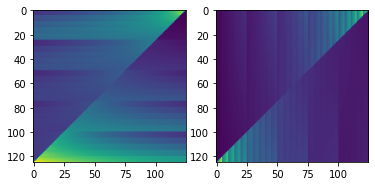

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].imshow(ADC_slice(np.asarray(b_values), test_image[:, :, :, 0]))
ax[1].imshow(T2_slice(np.asarray(TE_values), test_image[:, :, 0, :]))
#print(test_image[:,:,0,1].min())

In [21]:
def get_batch(batch_size=16):

    b_values = [0, 150, 1000, 1500]
    TE_values = [0, 13, 93, 143]

    b_TE = []
    for b in b_values:
        for TE in TE_values:
            b_TE.append((b,TE))
    
    D_ep = np.random.uniform(0.3, 0.7, batch_size)
    D_st = np.random.uniform(0.7, 1.7, batch_size)
    D_lu = np.random.uniform(2.7, 3, batch_size)
    T2_ep = np.random.uniform(20, 70, batch_size)
    T2_st = np.random.uniform(40, 100, batch_size)
    T2_lu = np.random.uniform(500, 1000, batch_size)

    v_ep = []
    v_st = []
    v_lu = []

    for _ in range(batch_size):
        seed = np.random.choice(3)
        if seed == 0:
            v_ep.append(np.random.uniform(0.01, 0.9, 1)[0])
            v_st.append(np.random.uniform(0.01, 1 - v_ep[-1], 1)[0])
            v_lu.append(1 - v_ep[-1] - v_st[-1])

        elif seed == 1:
            v_st.append(np.random.uniform(0.01, 0.9, 1)[0])
            v_lu.append(np.random.uniform(0.01, 1-v_st[-1], 1)[0])
            v_ep.append(1 - v_st[-1] - v_lu[-1])

        else:
            v_lu.append(np.random.uniform(0.01, 0.9, 1)[0])
            v_ep.append(np.random.uniform(0.01, 1-v_lu[-1], 1)[0])
            v_st.append(1 - v_ep[-1] - v_lu[-1])

        

    signal = np.zeros((batch_size, len(b_TE)), dtype=float)
    for sample in range(batch_size):
        for ctr, (b, TE) in enumerate(b_TE):
            S_ep = v_ep[sample]*np.exp(-b/1000*D_ep[sample])*np.exp(-TE/T2_ep[sample])
            S_st = v_st[sample]*np.exp(-b/1000*D_st[sample])*np.exp(-TE/T2_st[sample])
            S_lu = v_lu[sample]*np.exp(-b/1000*D_lu[sample])*np.exp(-TE/T2_lu[sample])
            signal[sample, ctr] = S_ep + S_st + S_lu

    D = np.asarray([D_ep, D_st, D_lu])
    T2 = np.asarray([T2_ep, T2_st, T2_lu])
    v = np.asarray([np.asarray(v_ep), np.asarray(v_st), np.asarray(v_lu)])
    
    return signal, D.T, T2.T, v.T

In [22]:
test = np.zeros((125, 125, 16))
ctr = 0
for b in range(4):
    for te in range(4):
        test[:, :, ctr] = test_image[:, :, b, te]
        ctr += 1
test = np.reshape(test, (125**2, 16))
test = torch.from_numpy(test)
test = test.float()
v_test2 = np.reshape(v_test, (125**2, 3))
D_test2 = np.reshape(D_test, (125**2, 3))
T2_test2 = np.reshape(T2_test, (125**2, 3))

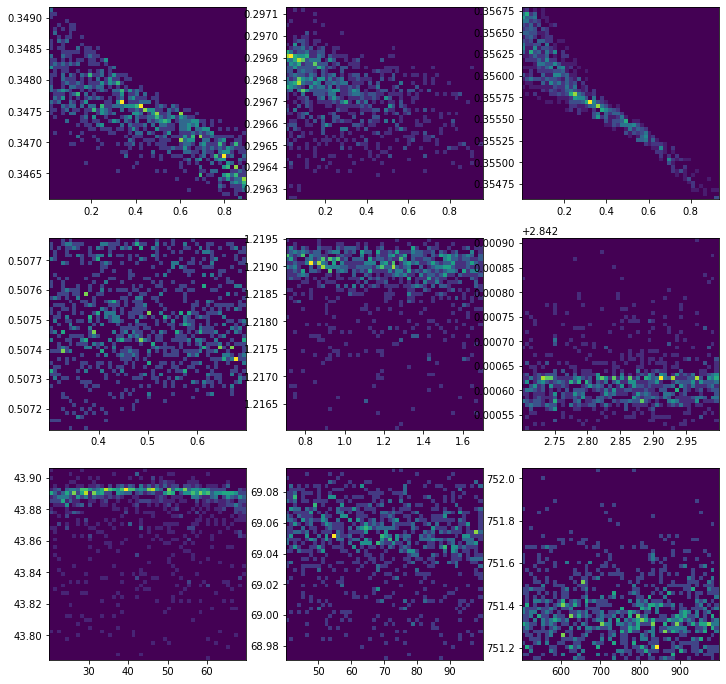

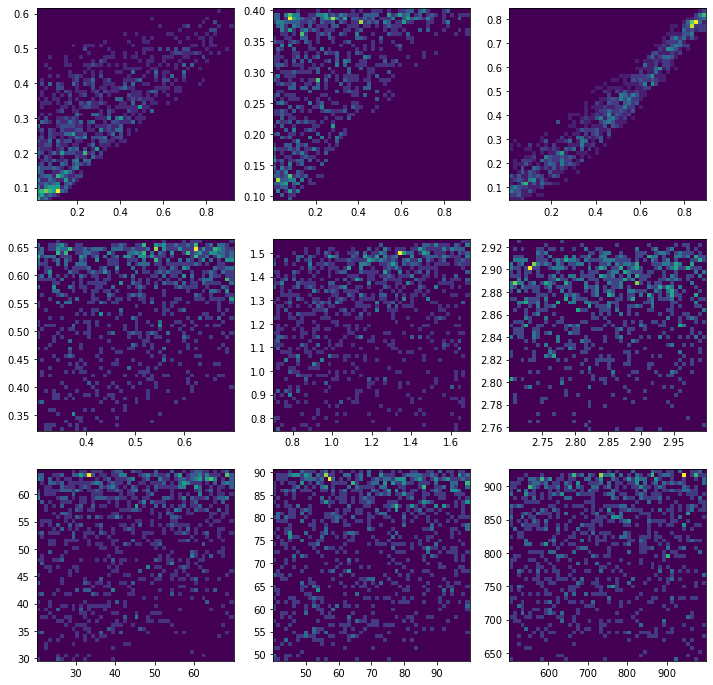

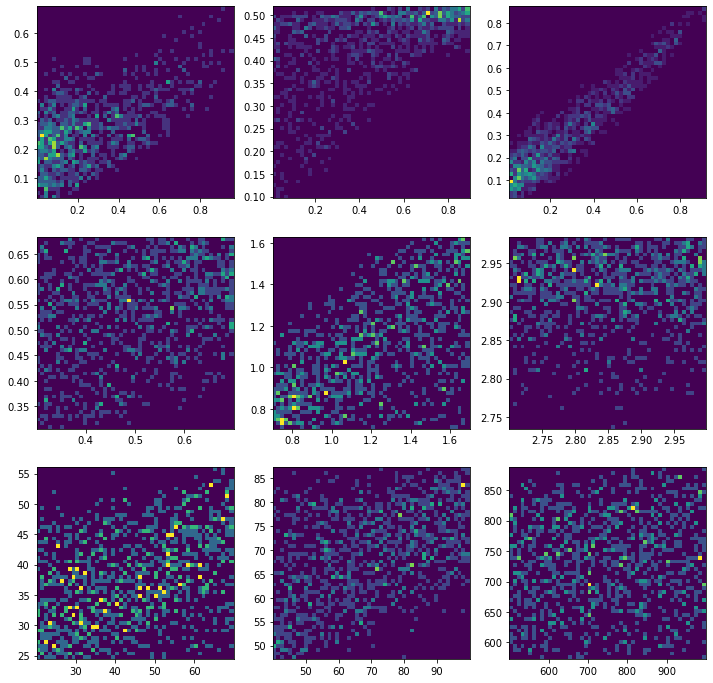

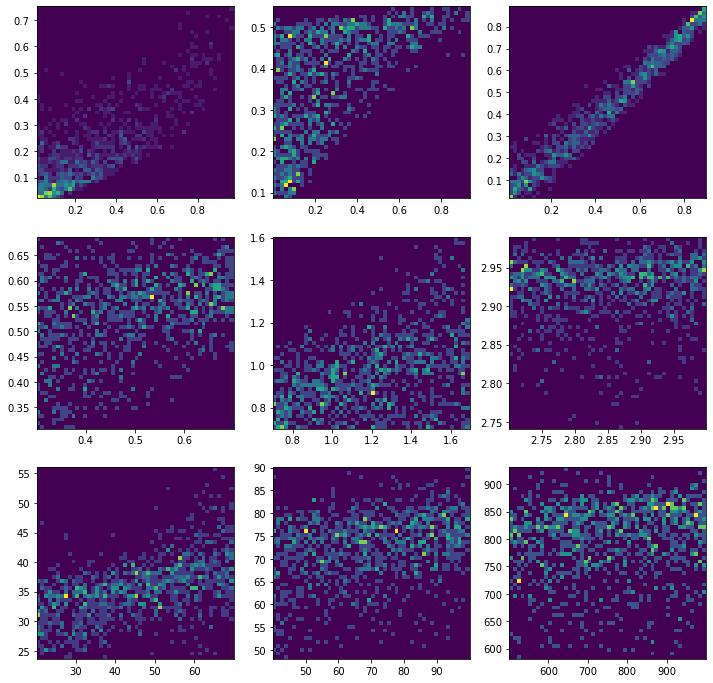

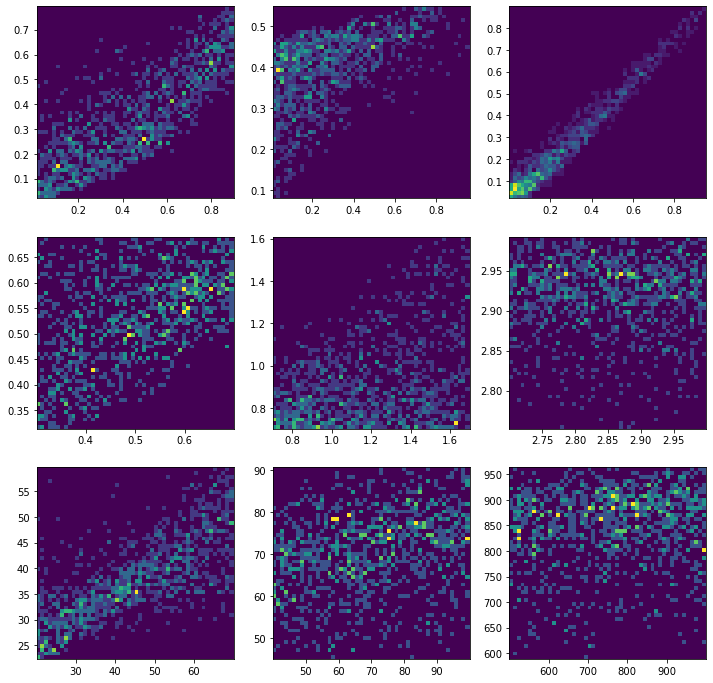

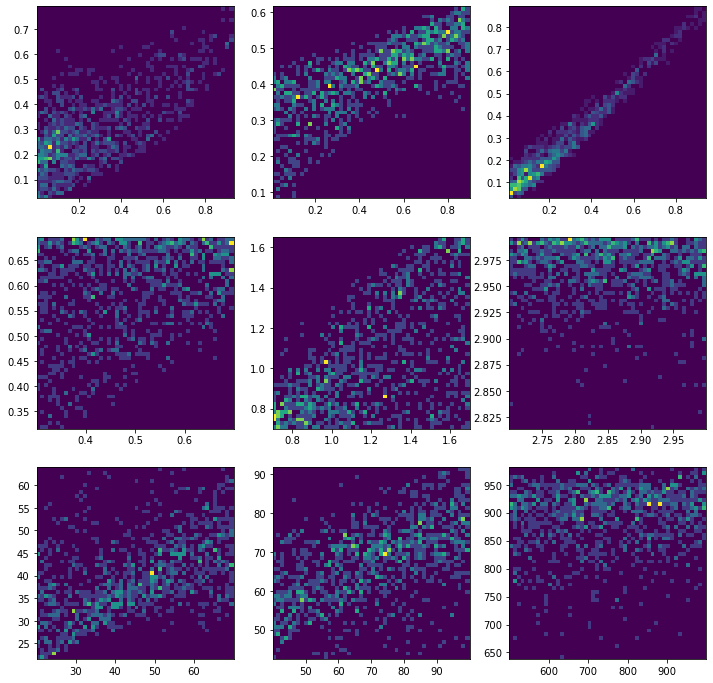

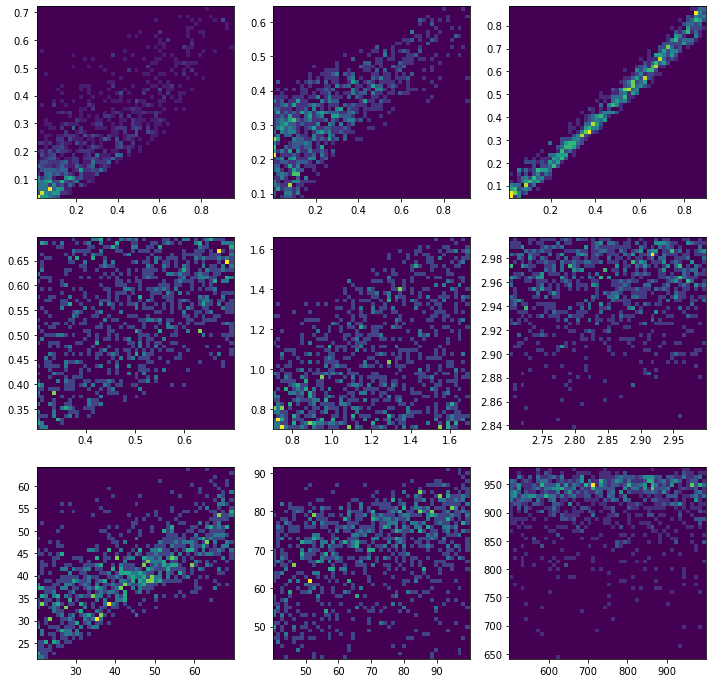

KeyboardInterrupt: 

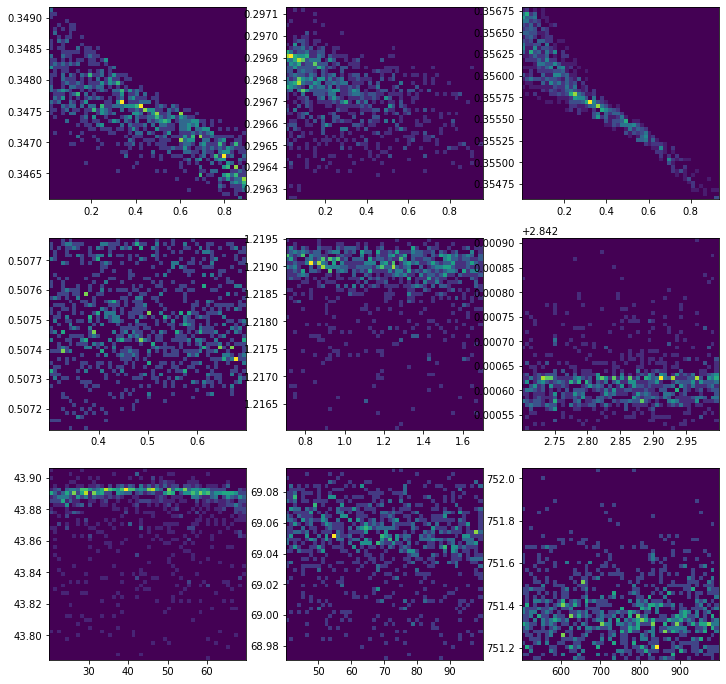

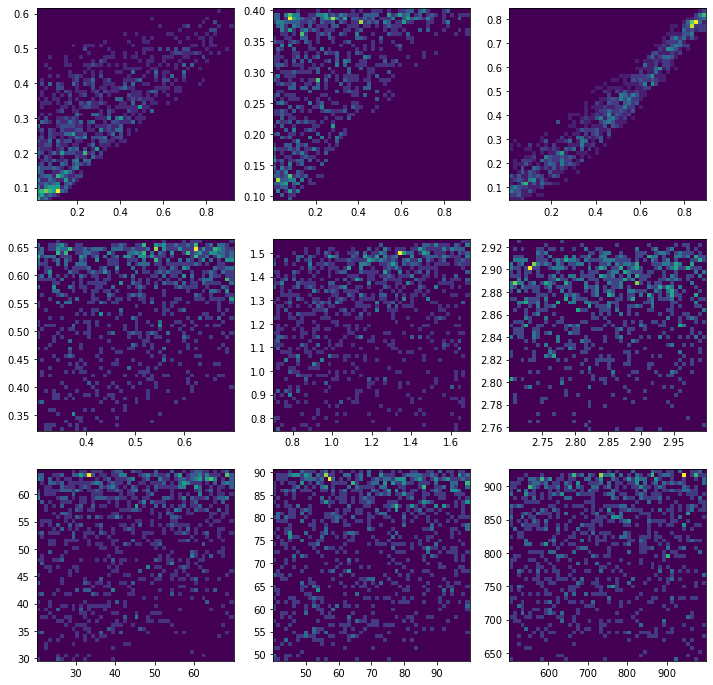

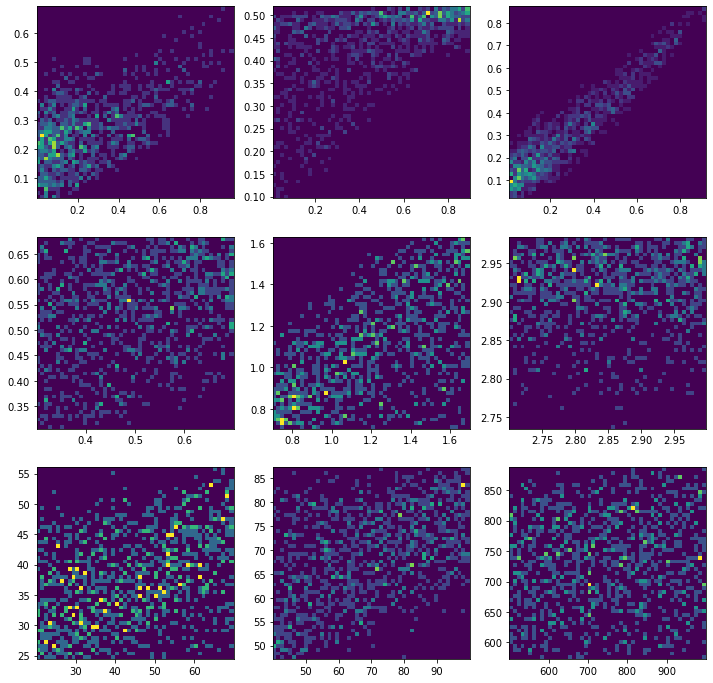

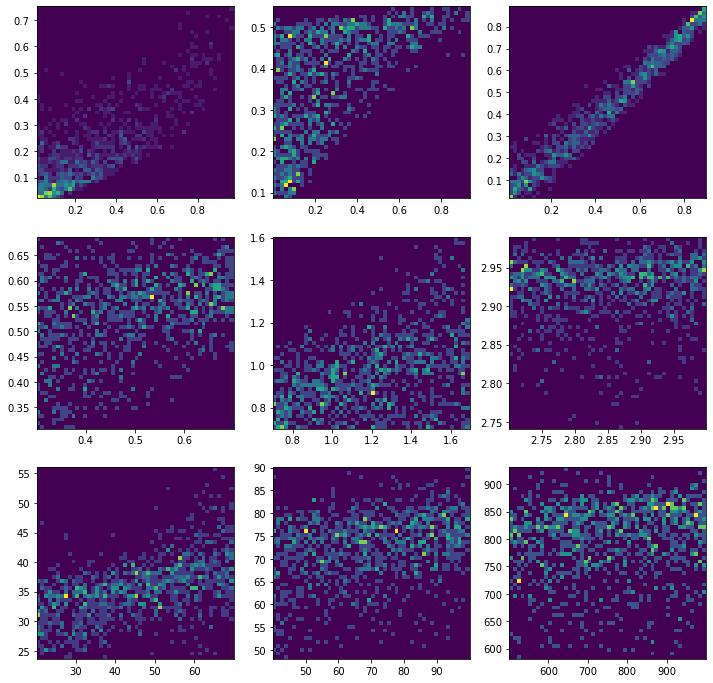

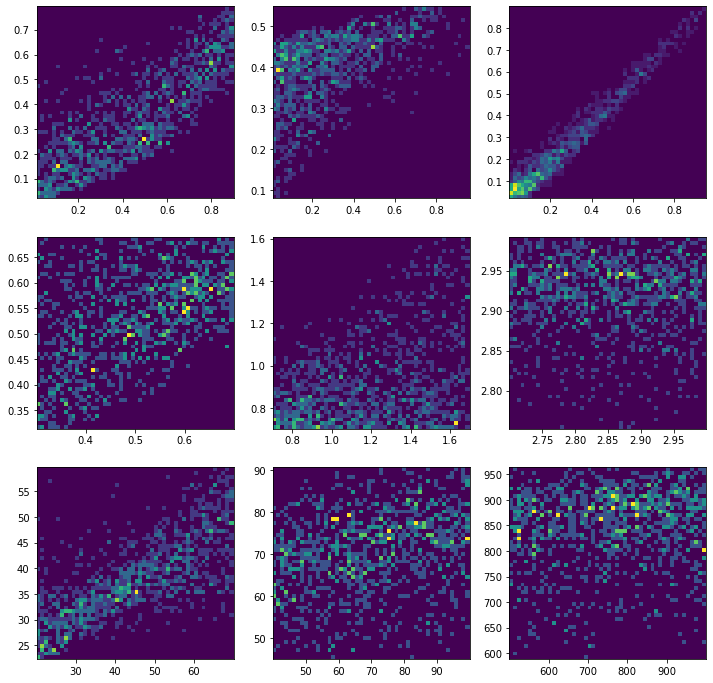

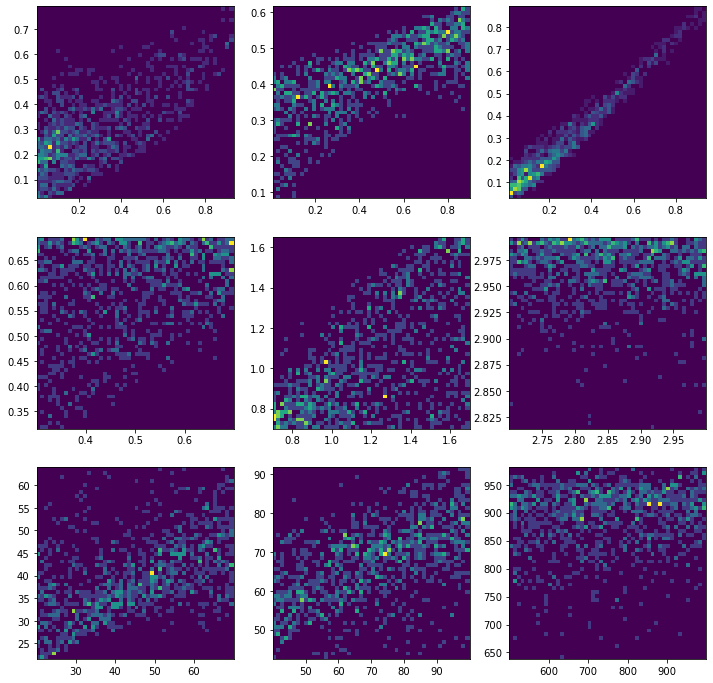

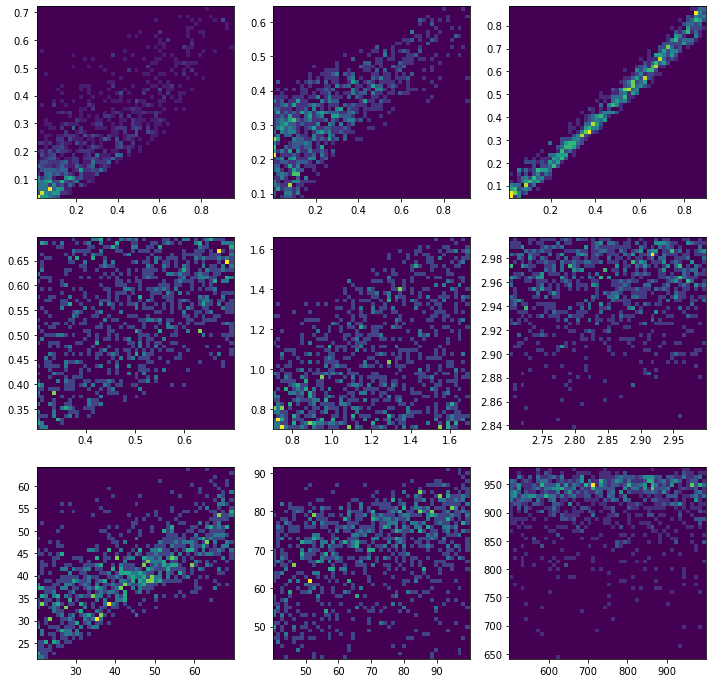

In [23]:
from IPython import display
from scipy.stats import gaussian_kde
%matplotlib inline
model =  PIA(hidden_dims=[64, 128]) 
params = list(model.encoder.parameters()) + list(model.v_predictor.parameters()) + list(model.D_predictor.parameters()) + list(model.T2_predictor.parameters())
optimizer = optim.Adam(params, lr=0.0001)


for ep in range(50000):
    total_loss = 0
    ctr = 1
    x, _, _, _ = get_batch(8)
    x = torch.from_numpy(x)
    x = x.float()
    optimizer.zero_grad()
    D, T2, v = model.encode(x)        
    recon = model.decode(D, T2, v)
    loss = model.loss_function(recon, x)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    if not ep % 100:
        test, D_test2, T2_test2, v_test2 = get_batch(1000)
        test = torch.from_numpy(test)
        test = test.float()
        D, T2, v = model.encode(test)
        v_ep_err = np.mean(abs(D_test2[:, 0] - D.detach().numpy()[:, 0]))
        print(f'Epithelium D estimate MAE = {v_ep_err}', end='\r')
        if not ep % 1000:



            fig, ax = plt.subplots(3,3, figsize=(12,12))
            ax[0,0].hist2d(v_test2[:,0], v.detach().numpy()[:, 0], bins = (50,50))
            ax[0,1].hist2d(v_test2[:,1], v.detach().numpy()[:, 1], bins = (50,50))
            ax[0,2].hist2d(v_test2[:,2], v.detach().numpy()[:, 2], bins = (50,50))
            ax[1,0].hist2d(D_test2[:,0], D.detach().numpy()[:, 0], bins = (50,50))
            ax[1,1].hist2d(D_test2[:,1], D.detach().numpy()[:, 1], bins = (50,50))
            ax[1,2].hist2d(D_test2[:,2], D.detach().numpy()[:, 2], bins = (50,50))

            ax[2,0].hist2d(T2_test2[:,0], T2.detach().numpy()[:, 0], bins = (50,50))
            #ax[0].plot(np.arange(0,1), np.arange(0,1), '.')
            #ax[0].axis('off')
            ax[2,1].hist2d(T2_test2[:,1], T2.detach().numpy()[:, 1], bins = (50,50))
            ax[2,2].hist2d(T2_test2[:,2], T2.detach().numpy()[:, 2], bins = (50,50))
            #ax[2].axis('off')
            display.display(plt.gcf())
    #display.clear_output(wait=True)
    #print(f'{total_loss/ctr}',end ="\r")

    # #v1 = v_real
    # v = v.detach().numpy()
    
    ctr += 1
    #print(f'{v1[0]:.2f}, {v1[1]:.2f}, {v1[2]:.2f} -> {v[0]:.2f}, {v[1]:.2f}, {v[2]:.2f}')

In [ ]:
v.shape

In [ ]:
#D, T2, v = D.T, T2.T, v.T
signal = torch.zeros((8,16))
ctr = 0
for b in b_values:
    for TE in TE_values:
        S_ep = v[0]*torch.exp(-b/1000*D[0])*torch.exp(-TE/T2[0])
        S_st = v[1]*torch.exp(-b/1000*D[1])*torch.exp(-TE/T2[1])
        S_lu = v[2]*torch.exp(-b/1000*D[2])*torch.exp(-TE/T2[2])
        signal[:, ctr] = S_ep + S_st + S_lu
        ctr +=1
        #         
        #         ctr += 1
        # signal = torch.Tensor(self.number_of_signals)
        # ctr = 0
        # for b in self.b_values:
        #     for TE in self.TE_values:
        #         S_ep = v[0]*torch.exp(-b/1000*D[0])*torch.exp(-TE/T2[0])
        #         S_st = v[1]*torch.exp(-b/1000*D[1])*torch.exp(-TE/T2[1])
        #         S_lu = v[2]*torch.exp(-b/1000*D[2])*torch.exp(-TE/T2[2])
        #         signal[ctr] = S_ep + S_st + S_lu
        #         ctr += 1
        # return signal

In [ ]:

model =  PIA(hidden_dims= [128, 128])

In [ ]:

from tqdm import tqdm
number_of_signals = 16
training_set = []

_all = [list(D_ep_), list(D_st_), list(D_lu_), list(T2_ep_), list(T2_st_), list(T2_lu_), list(_v_ep), list(_v_st)]
combs = list(itertools.product(*_all))

combs = [x for x in combs if x[-1] + x[-2] < 0.99]
print(len(combs))
print(combs[0])

In [ ]:
import re
import os
import mat73
import scipy.io as sio
import numpy as np
from scipy.optimize import curve_fit
import itertools
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [ ]:



for D_ep, D_st, D_lu, T2_ep, T2_st, T2_lu, v_st, v_ep in tqdm(combs):
    v_lu = 1 - v_ep - v_st
    #ctr = 0
    signal = np.zeros(number_of_signals, dtype=float)
    for ctr, (b, TE) in enumerate(b_TE):
        S_ep = v_ep*np.exp(-b/1000*D_ep)*np.exp(-TE/T2_ep)
        S_st = v_st*np.exp(-b/1000*D_st)*np.exp(-TE/T2_st)
        S_lu = v_lu*np.exp(-b/1000*D_lu)*np.exp(-TE/T2_lu)
        signal[ctr] = S_ep + S_st + S_lu
        #ctr += 1
    D = np.asarray([D_ep, D_st, D_lu])
    T2 = np.asarray([T2_ep, T2_st, T2_lu])
    v = np.asarray([v_ep, v_st, v_lu])
    training_set.append((signal, v, D, T2))
        

In [ ]:

model =  PIA(hidden_dims= [128, 128])
optimizer = optim.Adam(model.encoder.parameters(), lr=0.0003)


for ep in range(1000):
    total_loss = 0
    ctr = 1
    for x, v_real, D_real, T2_real in training_set:   
        x = torch.from_numpy(x)
        x = x.float()
        optimizer.zero_grad()
        D, T2, v = model.encode(x)        
        recon = model.decode(D, T2, v)
        loss = model.loss_function(recon, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        v1 = v_real
        v = v.detach().numpy()
        print(f'{total_loss/ctr}',end ="\r")
        ctr += 1
    print(f'{v1[0]:.2f}, {v1[1]:.2f}, {v1[2]:.2f} -> {v[0]:.2f}, {v[1]:.2f}, {v[2]:.2f}')
    

        
    

In [ ]:
hybrid_crop2 = np.reshape(hybrid_crop, (55, 45, 16))

In [ ]:
hybrid_crop[10,10,:, :]

In [ ]:
def adc_voxel(b, S):
    min_adc = 0
    max_adc = 3.0
    all_bs = [[[b[i], np.log(S[i] + eps)]] for i in range(len(b))]
    combs = [x for x in itertools.product(*all_bs)]
    def lms_adc(inpt):
        sum_xi_yi = sum([x[0]*x[1] for x in inpt])
        sum_yj = sum([x[1] for x in inpt])
        sum_xi_sum_yj = sum([x[0]*sum_yj for x in inpt])
        sum_x2 = sum([x[0]**2 for x in inpt])
        sum_x = sum([x[0] for x in inpt])
        adc = -(len(inpt)*sum_xi_yi - sum_xi_sum_yj)/(len(inpt)*sum_x2 - sum_x**2 )*1000
        return adc
    return max(min(lms_adc(combs[0]), max_adc), min_adc)

In [ ]:
from skimage import morphology
from skimage import segmentation


In [ ]:
from torch import optim
D_mean = torch.from_numpy(np.asarray([0.55, 1.3, 2.8]))
T2_mean = torch.from_numpy(np.asarray([50, 70, 750]))
v_ep = np.zeros_like(hybrid_crop2[:,:,1])
v_st = np.zeros_like(hybrid_crop2[:,:,1])
v_lu = np.zeros_like(hybrid_crop2[:,:,1])
#model =  HybridVAE(number_of_signals=16, hidden_dims= [128, 128])
optimizer = optim.Adam(model.encoder.parameters(), lr=0.0003)
for ep in tqdm(range(1)):
    total_loss = 0
    for row in range(hybrid_crop2.shape[0]):
        for col in range(hybrid_crop2.shape[1]):
            if hybrid_crop2[row, col, 0] > 5000:
                voxel = hybrid_crop2[row, col, :]/hybrid_crop2[row, col, 0]
                optimizer.zero_grad()
                x = torch.from_numpy(voxel).float()
                D_var, T2_var, v = model.encode(x)        
                D, T2 = model.sample(D_mean, T2_mean, D_var, T2_var)
                recon = model.decode(D, T2, v)
                loss = model.loss_function(recon, x)
                loss['loss'].backward()
                optimizer.step()
                total_loss += loss['loss'].item()
                v_ep[row, col] = v.detach().numpy()[0]
                v_st[row, col] = v.detach().numpy()[1]
                v_lu[row, col] = v.detach().numpy()[2]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im = ax[0].imshow(v_ep,  cmap = 'jet')
im = ax[1].imshow(v_st,  cmap = 'jet')
im = ax[2].imshow(v_lu,  cmap = 'jet')
fig.colorbar(im, ax=ax[0],shrink=0.75)
fig.colorbar(im, ax=ax[1],shrink=0.75)
fig.colorbar(im, ax=ax[2],shrink=0.75)
ax[0].set_title('Epithelium Volume')
ax[1].set_title('Stroma Volume')
ax[2].set_title('Lumen Volume')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
imageMap=  (v_ep > 0.4)*(v_lu <= 0.2)
b0_th = 5000
data_th = 3#1000
signal = np.squeeze(hybrid_crop[:,:, 3, 0])
b0 = np.squeeze(hybrid_crop[:,:, 0, 0])
mask = b0 > b0_th
mask2 = signal > data_th
data_segmented = mask2*signal
b0_segmented = mask*b0
#mask = mask*mask2
b_values = [0, 150, 1000, 1500]
adc_map = ADC_slice(b_values, hybrid_crop[:,:, :, 0])
fig, ax = plt.subplots(1, figsize=(6,6))
fig.suptitle('predicted cancer map')
ax.imshow(adc_map, cmap='gray')
cancer_map = np.multiply(imageMap.astype(float), mask.astype(float))
cancer_map = np.multiply(cancer_map, mask2.astype(float))
cancer_map = morphology.remove_small_objects(cancer_map.astype(bool), min_size=1, connectivity=1)
cancer_map = cancer_map.astype(float)
cancer_map[cancer_map==0] = np.nan
ax.imshow(cancer_map, cmap='autumn', alpha = 0.4)
ax.axis('off')

In [ ]:
plt.fill_between(10, 20, 30)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple


class HybridVAE():

    def __init__(self, number_of_signals,
                 hidden_dims: List = None):
        super(HybridVAE, self).__init__()
        
        self.number_of_signals = number_of_signals
        self.number_of_compartments = 3
        self.D_delta = 0.2
        self.T2_delta = 20
        self.b_values = [0, 150, 1000, 1500]
        self.TE_values = [0, 13, 93, 143]
        self.D_predictor = nn.Linear(hidden_dims[-1], self.number_of_compartments)
        self.T2_predictor = nn.Linear(hidden_dims[-1], self.number_of_compartments)
        self.v_predictor = nn.Linear(hidden_dims[-1], self.number_of_compartments)
        self.softmax = torch.nn.Softmax(dim=0)
        self.relu = nn.ReLU()

        
        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        in_channels = number_of_signals
        for h_dim in hidden_dims:
            
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_channels, out_features=h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        


    def encode(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(x)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        D_var = self.D_delta*torch.tanh(self.D_predictor(result))
        T2_var = self.T2_delta*torch.tanh(self.T2_predictor(result))
        v = self.softmax(self.v_predictor(result))

        return [D_var, T2_var, v]

    def decode(self, D, T2, v):
        """
            Maps the given latent codes onto the signal space.
            param D: [D_ep, D_st, D_lu]
            param T2: [T2_ep, T2_st, T2_lu]
            param v: [v_ep, v_st, v_lu]
            return: (Tensor) signal estimate
        """
        signal = torch.Tensor(self.number_of_signals)
        ctr = 0
        for b in self.b_values:
            for TE in self.TE_values:
                S_ep = v[0]*torch.exp(-b/1000*D[0])*torch.exp(-TE/T2[0])
                S_st = v[1]*torch.exp(-b/1000*D[1])*torch.exp(-TE/T2[1])
                S_lu = v[2]*torch.exp(-b/1000*D[2])*torch.exp(-TE/T2[2])
                signal[ctr] = S_ep + S_st + S_lu
                ctr += 1
        return signal
    
#     def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
#         """
#         Reparameterization trick to sample from N(mu, var) from
#         N(0,1).
#         :param mu: (Tensor) Mean of the latent Gaussian [B x D]
#         :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
#         :return: (Tensor) [B x D]
#         """
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return eps * std + mu
    
    def forward(self, x):
        D, T2, v = self.encode(x)
        return  [self.decode(D, T2, v), x, D, T2, v]


    def loss_function(self, recons, x):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + 
                                      \frac{\sigma^2 + \mu^2}{2}
                                      -\frac{1}{2}

        """

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        
        recons_loss =F.mse_loss(recons, x)
        #kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        loss = recons_loss# + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach()}#, 'KLD':-kld_loss.detach()}

    def sample(self, D_mean, T2_mean, D_var, T2_var):
        """
            Samples from the latent space and return the corresponding
            image parameter map.
            return: (Tensor)
            
        """
        eps_D = torch.randn(self.number_of_compartments)
        eps_T2 = torch.randn(self.number_of_compartments)
        #return eps_D * D_var + D_mean , eps_T2 * T2_var + T2_mean
        return D_mean + D_var , T2_mean + T2_var